## Cases distribution

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
cases_citations = pd.read_csv('../inputdata/all_cases_citations.csv')

In [3]:
case_cites = cases_citations\
    .groupby('source')\
    .count()\
    .sort_values('target', ascending=False)\
    .reset_index()\
    .rename(columns = {'source':'case','target':'links'})

In [4]:
case_is_cited = cases_citations\
    .groupby('target')\
    .count()\
    .sort_values('source', ascending=False)\
    .reset_index()\
    .rename(columns = {'target':'case','source':'links'})3

In [17]:
#case_is_cited

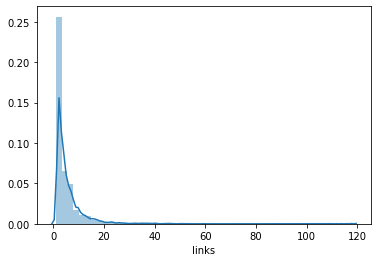

In [5]:
sns.distplot(case_is_cited['links'])

In [6]:
case_is_cited.describe()

,links
count,9663.000000
mean,4.530684
std,5.719543
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,118.000000


#### One-Sample Kolmogorov-Smirnov Test for comparing with theoretical distribuition

In [7]:
cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "anglit",          #Anglit
    "arcsine",         #Arcsine
    "beta",            #Beta
    "betaprime",       #Beta Prime
    "bradford",        #Bradford
    "burr",            #Burr
    "cauchy",          #Cauchy
    "chi",             #Chi
    "chi2",            #Chi-squared
    "cosine",          #Cosine
    "dgamma",          #Double Gamma
    "dweibull",        #Double Weibull
    "erlang",          #Erlang
    "expon",           #Exponential
    "exponweib",       #Exponentiated Weibull
    "exponpow",        #Exponential Power
    "fatiguelife",     #Fatigue Life (Birnbaum-Sanders)
    "foldcauchy",      #Folded Cauchy
    "f",               #F (Snecdor F)
    "fisk",            #Fisk
    "foldnorm",        #Folded Normal
    "frechet_r",       #Frechet Right Sided, Extreme Value Type II
    "frechet_l",       #Frechet Left Sided, Weibull_max
    "gamma",           #Gamma
    "gausshyper",      #Gauss Hypergeometric
    "genexpon",        #Generalized Exponential
    "genextreme",      #Generalized Extreme Value
    "gengamma",        #Generalized gamma
    "genlogistic",     #Generalized Logistic
    "genpareto",       #Generalized Pareto
    "genhalflogistic", #Generalized Half Logistic
    "gilbrat",         #Gilbrat
    "gompertz",        #Gompertz (Truncated Gumbel)
    "gumbel_l",        #Left Sided Gumbel, etc.
    "gumbel_r",        #Right Sided Gumbel
    "halfcauchy",      #Half Cauchy
    "halflogistic",    #Half Logistic
    "halfnorm",        #Half Normal
    "hypsecant",       #Hyperbolic Secant
    "invgamma",        #Inverse Gamma
#    "invnorm",         #Inverse Normal
    "invweibull",      #Inverse Weibull
    "johnsonsb",       #Johnson SB
    "johnsonsu",       #Johnson SU
    "laplace",         #Laplace
    "logistic",        #Logistic
    "loggamma",        #Log-Gamma
    "loglaplace",      #Log-Laplace (Log Double Exponential)
    "lognorm",         #Log-Normal
    "lomax",           #Lomax (Pareto of the second kind)
    "maxwell",         #Maxwell
    "mielke",          #Mielke's Beta-Kappa
    "nakagami",        #Nakagami
    "ncx2",            #Non-central chi-squared
#    "ncf",             #Non-central F
    "nct",             #Non-central Student's T
    "pareto",          #Pareto
    "powerlaw",        #Power-function
    "powerlognorm",    #Power log normal
    "powernorm",       #Power normal
    "rdist",           #R distribution
    "reciprocal",      #Reciprocal
    "rayleigh",        #Rayleigh
    "rice",            #Rice
    "recipinvgauss",   #Reciprocal Inverse Gaussian
    "semicircular",    #Semicircular
    "t",               #Student's T
    "triang",          #Triangular
    "truncexpon",      #Truncated Exponential
    "truncnorm",       #Truncated Normal
    "tukeylambda",     #Tukey-Lambda
    "uniform",         #Uniform
    "vonmises",        #Von-Mises (Circular)
    "wald",            #Wald
    "weibull_min",     #Minimum Weibull (see Frechet)
    "weibull_max",     #Maximum Weibull (see Frechet)
    "wrapcauchy",      #Wrapped Cauchy
    "ksone",           #Kolmogorov-Smirnov one-sided (no stats)
    "kstwobign"]       #Kolmogorov-Smirnov two-sided test for Large N

In [8]:
vector = case_is_cited.links.values
np.random.seed(9876)
results = []
for cdf in cdfs:
    #fit our data set against every probability distribution
    parameters = eval("scipy.stats."+cdf+".fit(vector)")
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(vector, cdf, args=parameters)
    if D < 1:
        results.append((cdf.ljust(16),p,D))

In [9]:
distribution_tests = pd.DataFrame(results)\
    .dropna()\
    .rename(columns = {0:'dist',1:'p-value',2:'D-statistic'})\
    .sort_values('D-statistic', ascending=False)

In [10]:
distribution_tests.head(10)

,dist,p-value,D-statistic
24,frechet_l,0.0,0.857780
73,weibull_max,0.0,0.857780
74,ksone,0.0,0.841760
70,uniform,0.0,0.841760
3,arcsine,0.0,0.737694
68,truncnorm,0.0,0.704440
60,reciprocal,0.0,0.704440
41,invgamma,0.0,0.704428
20,f,0.0,0.704416
31,genpareto,0.0,0.704409


In [11]:
#equivalent
#np.percentile(case_is_cited['links'], 99)
#case_is_cited.quantile(.99)

In [12]:
#case_is_cited['quantile'] = case_is_cited['links'].rank(pct=True)

---

In [13]:
from statsmodels.stats.power import  tt_ind_solve_power
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def test_ttest_power_diff(mean, std, sample1_size=None, alpha=0.05, desired_power=0.8, mean_diff_percentages=[0.1, 0.05]):
    '''
    calculates the power function for a given mean and std. the function plots a graph showing the comparison between desired mean differences
    :param mean: the desired mean
    :param std: the std value
    :param sample1_size: if None, it is assumed that both samples (first and second) will have same size. The function then will
    walk through possible sample sizes (up to 100, hardcoded).
    If this value is not None, the function will check different alternatives for sample 2 sizes up to sample 1 size.
    :param alpha: alpha default value is 0.05
    :param desired_power: will use this value in order to mark on the graph
    :param mean_diff_percentages: iterable list of percentages. A line per value will be calculated and plotted.
    :return: None
    '''
    fig, ax = plt.subplots()
    for mean_diff_percent in mean_diff_percentages:
        mean_diff = mean_diff_percent * mean
        effect_size = mean_diff / std

        print('Mean diff: ', mean_diff)
        print('Effect size: ', effect_size)

        powers = []

        max_size  = sample1_size
        if sample1_size is None:
            max_size = 100

        sizes = np.arange(1, max_size, 2)
        for sample2_size in sizes:
            if(sample1_size is None):
                n = tt_ind_solve_power(effect_size=effect_size, nobs1=sample2_size, alpha=alpha, ratio=1.0, alternative='two-sided')
                print('tt_ind_solve_power(alpha=', alpha, 'sample2_size=', sample2_size, '): sample size in *second* group: {:.5f}'.format(n))
            else:
                n = tt_ind_solve_power(effect_size=effect_size, nobs1=sample1_size, alpha=alpha, ratio=(1.0*sample2_size/sample1_size), alternative='two-sided')
                print('tt_ind_solve_power(alpha=', alpha, 'sample2_size=', sample2_size, '): sample size *each* group: {:.5f}'.format(n))

            powers.append(n)

        try: # mark the desired power on the graph
            z1 = interp1d(powers, sizes)
            results = z1(desired_power)

            plt.plot([results], [desired_power], 'gD')
        except Exception as e:
            print("Error: ", e)
            #ignore

        plt.title('Power vs. Sample Size')
        plt.xlabel('Sample Size')
        plt.ylabel('Power')

        plt.plot(sizes, powers, label='diff={:2.0f}%'.format(100*mean_diff_percent)) #, '-gD')

    plt.legend()
    plt.show()

Mean diff:  1.0
Effect size:  0.5
tt_ind_solve_power(alpha= 0.05 sample2_size= 1 ): sample size in *second* group: nan
tt_ind_solve_power(alpha= 0.05 sample2_size= 3 ): sample size in *second* group: 0.07685
tt_ind_solve_power(alpha= 0.05 sample2_size= 5 ): sample size in *second* group: 0.10769
tt_ind_solve_power(alpha= 0.05 sample2_size= 7 ): sample size in *second* group: 0.13856
tt_ind_solve_power(alpha= 0.05 sample2_size= 9 ): sample size in *second* group: 0.16956
tt_ind_solve_power(alpha= 0.05 sample2_size= 11 ): sample size in *second* group: 0.20063
tt_ind_solve_power(alpha= 0.05 sample2_size= 13 ): sample size in *second* group: 0.23163
tt_ind_solve_power(alpha= 0.05 sample2_size= 15 ): sample size in *second* group: 0.26244
tt_ind_solve_power(alpha= 0.05 sample2_size= 17 ): sample size in *second* group: 0.29296
tt_ind_solve_power(alpha= 0.05 sample2_size= 19 ): sample size in *second* group: 0.32307
tt_ind_solve_power(alpha= 0.05 sample2_size= 21 ): sample size in *second* 

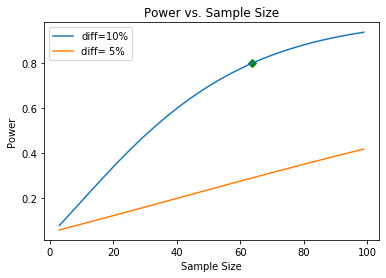

In [14]:
mean=10; std=2
test_ttest_power_diff(mean, std, sample1_size=None, alpha=0.05, desired_power=0.8, mean_diff_percentages=[0.1, 0.05])